<a href="https://colab.research.google.com/github/Samuel-Ovuehor/Python-Code/blob/main/TrafficEstimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
!pip install rasterstats
!pip install rasterio
!pip install contextily


In [47]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import shapely as shp
import rasterstats as rs
import requests
import json
import contextily as ctx


##The following code loads the file with the summary of scoot loop sensors in Hull

In [48]:
# Step 1: Get the JSON data from the URL
url = "https://opendata.hullcc.gov.uk/dataset/30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3/resource/90e1cce0-295e-4fa7-aa21-ebc4f3e8e8d4/download/scoot_loop_resources_full.json"
response = requests.get(url)

# Step 2: Convert the JSON response to a Python object
my_response = response.json()

# Step 3: Create a DataFrame from the JSON data
my_data = pd.json_normalize(my_response)

# Step 4: Filter out rows where longitude is 0
my_data = my_data[my_data['longitude'] != 0]


In [49]:
my_data.head(3)

,id,resource_id,package_id,name,description,longitude,latitude
0,9601773,155c6177-a011-41a0-b8d6-2232fc07aeeb,30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3,N10111A,TSI033 ANLABY ROAD / WALTON STREET - TRAVELLI...,-0.373631,53.745063
1,9601774,d8b65526-90e6-4dcc-8386-aeb827b124d5,30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3,N10111B,TSI033 ANLABY ROAD / WALTON STREET - TRAVELLI...,-0.373455,53.744752
2,9601775,80cf0bd9-a782-42a7-a45f-7851483aa9b6,30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3,N10111C,TSI033 ANLABY ROAD / WALTON STREET - TRAVELLI...,-0.373497,53.744744


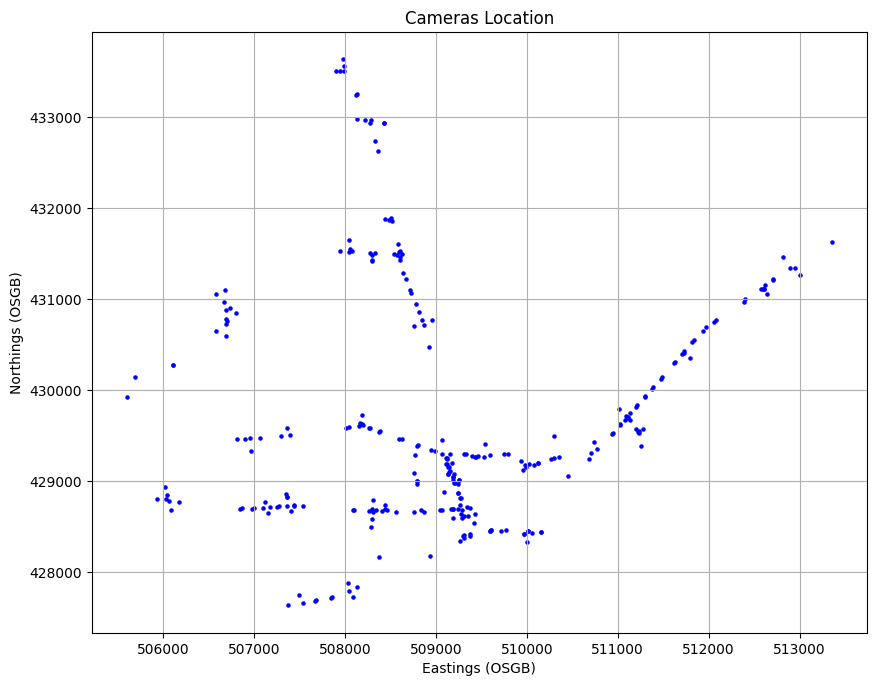

In [50]:
from shapely.geometry import Point

# Step 1: Convert to GeoDataFrame
# Create geometry from latitude and longitude
my_data['geometry'] = my_data.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)

# Create a GeoDataFrame
sf_cameras = gpd.GeoDataFrame(my_data, geometry='geometry', crs=4326)

# Step 2: Transform the coordinate reference system to EPSG:27700
sf_cameras = sf_cameras.to_crs(epsg=27700)

# Step 3: Plot using Matplotlib
# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Add basemap (you might need to customize this part or use additional libraries)
# Here we will just plot the points for simplicity
sf_cameras.plot(ax=ax, color='blue', markersize=5)

# Show the plot
plt.title("Cameras Location")
plt.xlabel("Eastings (OSGB)")
plt.ylabel("Northings (OSGB)")
plt.grid()
plt.show()


There are some issues with the coordinates of some sites. The following code fixes the problem

In [51]:
my_data.loc[my_data['latitude'] < 0, ['longitude', 'latitude']] = my_data.loc[my_data['latitude'] < 0, ['longitude', 'latitude']].iloc[::-1].values


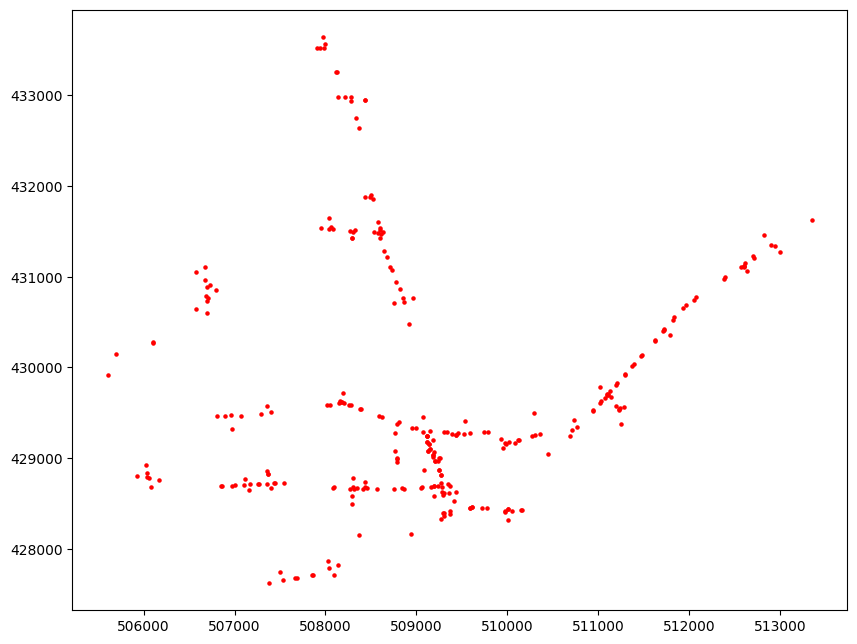

In [52]:
import re

# Replace and split the description column
my_data['description'] = my_data['description'].str.replace("HE SITE - ", "HE SITE _ ")
my_data[['desc', 'direction', 'url', 'coord']] = my_data['description'].str.split(' - ', expand=True)

# Drop the 'coord' column
my_data_expanded = my_data.drop(columns=['coord'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    my_data_expanded,
    geometry=gpd.points_from_xy(my_data_expanded['longitude'], my_data_expanded['latitude']),
    crs="EPSG:4326"
)

# Transform the coordinate reference system to EPSG:27700
gdf = gdf.to_crs(epsg=27700)

# Plot using geopandas (or use contextily for a basemap)
ax = gdf.plot(marker='o', color='red', markersize=5, figsize=(10, 10))

##Grouping sensors

In [53]:
# Buffer the sensor data by 20 units (assuming meters)
sensors_buffer = gdf.buffer(20)

In [54]:
def tmap_mode(mode):
    if mode == "view":
        print("Switched to view mode.")
    else:
        print("Mode not recognized.")

# Set the mode to 'view'
tmap_mode("view")


Switched to view mode.


In [77]:
import folium

# Ensure gdf and sensors_buffer are in the same CRS and reproject if necessary
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

if sensors_buffer.crs != "EPSG:4326":
    sensors_buffer = sensors_buffer.to_crs("EPSG:4326")

# Filter the buffer GeoDataFrame for specific names
filtered_sensors = gdf[gdf['name'].isin(["N44131F", "N44131X", "N44131H"])]

# Create a base map centered around the mean coordinates of the original points
m = folium.Map(location=[gdf.geometry.y.mean(), gdf.geometry.x.mean()], zoom_start=14, tiles='OpenStreetMap')


# Add original points to the map with larger markers for visibility
for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color='red', icon='info-sign', prefix='fa')  # Font Awesome icon
    ).add_to(m)

# Display the interactive map
m.save('interactive_map.html')  # Save to an HTML file
m  # In a Jupyter Notebook, this will render the map inline.


In [85]:
sf_sensors_raw = gpd.GeoDataFrame(
    my_data_expanded,  # Your DataFrame
    geometry=gpd.points_from_xy(my_data_expanded.longitude, my_data_expanded.latitude),
    crs="EPSG:4326"  # Set the initial CRS
)



In [86]:
print(my_data_expanded.head())  # Check the first few rows of your DataFrame
print(my_data_expanded[['longitude', 'latitude']].isnull().sum())  # Check for NaNs


        id                           resource_id  \
0  9601773  155c6177-a011-41a0-b8d6-2232fc07aeeb   
1  9601774  d8b65526-90e6-4dcc-8386-aeb827b124d5   
2  9601775  80cf0bd9-a782-42a7-a45f-7851483aa9b6   
3  9601776  c93c3abe-abfe-48f5-a99b-6dd958f09fc2   
4  9601777  2aeb1f0d-5daf-4304-9b50-d3436c72a52a   

                             package_id     name  \
0  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111A   
1  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111B   
2  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111C   
3  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111D   
4  30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111E   

                                         description  longitude   latitude  \
0  TSI033 ANLABY ROAD / WALTON STREET  - TRAVELLI...  -0.373631  53.745063   
1  TSI033 ANLABY ROAD / WALTON STREET  - TRAVELLI...  -0.373455  53.744752   
2  TSI033 ANLABY ROAD / WALTON STREET  - TRAVELLI...  -0.373497  53.744744   
3  TSI033 ANLABY ROAD / WALTON STREET  - TRAVELLI...  -0.37086

In [87]:
sf_sensors_raw = sf_sensors_raw.to_crs("EPSG:27700")


In [88]:
buffer_groups = sensors_buffer.unary_union  # Create a single geometry (MultiPolygon or Polygon)


<ipython-input-88-048429d2fce5>:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_groups = sensors_buffer.unary_union  # Create a single geometry (MultiPolygon or Polygon)


In [89]:
print(sensors_buffer)  # Ensure sensors_buffer is not empty


0      POLYGON ((-0.37333 53.74506, -0.37333 53.74504...
1      POLYGON ((-0.37315 53.74475, -0.37315 53.74473...
2      POLYGON ((-0.37319 53.74474, -0.3732 53.74472,...
3      POLYGON ((-0.37056 53.74381, -0.37056 53.7438,...
4      POLYGON ((-0.37265 53.74336, -0.37265 53.74334...
                             ...                        
328    POLYGON ((-0.36326 53.73534, -0.36326 53.73533...
329    POLYGON ((-0.36341 53.73606, -0.36341 53.73604...
330    POLYGON ((-0.36186 53.73566, -0.36187 53.73564...
331    POLYGON ((-0.36253 53.73465, -0.36253 53.73464...
332    POLYGON ((-0.35818 53.73858, -0.35818 53.73856...
Length: 296, dtype: geometry


In [90]:
buffer_groups_gdf = gpd.GeoDataFrame(geometry=[buffer_groups], crs=sensors_buffer.crs)


In [92]:
sensors_overlap = gpd.overlay(buffer_groups_gdf, sf_sensors_raw, how='intersection')


<ipython-input-92-9a064133d38e>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:27700

  sensors_overlap = gpd.overlay(buffer_groups_gdf, sf_sensors_raw, how='intersection')


In [93]:
print(buffer_groups_gdf)  # Check the buffer geometry
print(sf_sensors_raw)      # Check the sensors GeoDataFrame


                                            geometry
0  MULTIPOLYGON (((-0.37351 53.73388, -0.37353 53...
           id                           resource_id  \
0     9601773  155c6177-a011-41a0-b8d6-2232fc07aeeb   
1     9601774  d8b65526-90e6-4dcc-8386-aeb827b124d5   
2     9601775  80cf0bd9-a782-42a7-a45f-7851483aa9b6   
3     9601776  c93c3abe-abfe-48f5-a99b-6dd958f09fc2   
4     9601777  2aeb1f0d-5daf-4304-9b50-d3436c72a52a   
..        ...                                   ...   
328  14007769  4f405154-06e1-4749-aed9-f172208eb32a   
329  14007774  46850c98-edce-4e88-9ddb-84b278d99c47   
330  14007765  d1af3056-5b6a-4788-9bb4-c81237d82895   
331  14007766  f38399b5-6c1c-432d-8f13-93f665ee3c49   
332  20521105  d1ed9bbe-ab81-4a8f-85e3-26fc5fed46c5   

                               package_id     name  \
0    30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111A   
1    30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111B   
2    30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111C   
3    30fd3969-556

In [94]:
sensors_overlap_boolean = sf_sensors_raw.geometry.intersects(buffer_groups)


In [95]:
# Display the result
print("sensors_overlap:")
print(sensors_overlap)

sensors_overlap:
Empty GeoDataFrame
Columns: [id, resource_id, package_id, name, description, longitude, latitude, desc, direction, url, geometry]
Index: []


sf_sensors_raw:
           id                           resource_id  \
0     9601773  155c6177-a011-41a0-b8d6-2232fc07aeeb   
1     9601774  d8b65526-90e6-4dcc-8386-aeb827b124d5   
2     9601775  80cf0bd9-a782-42a7-a45f-7851483aa9b6   
3     9601776  c93c3abe-abfe-48f5-a99b-6dd958f09fc2   
4     9601777  2aeb1f0d-5daf-4304-9b50-d3436c72a52a   
..        ...                                   ...   
328  14007769  4f405154-06e1-4749-aed9-f172208eb32a   
329  14007774  46850c98-edce-4e88-9ddb-84b278d99c47   
330  14007765  d1af3056-5b6a-4788-9bb4-c81237d82895   
331  14007766  f38399b5-6c1c-432d-8f13-93f665ee3c49   
332  20521105  d1ed9bbe-ab81-4a8f-85e3-26fc5fed46c5   

                               package_id     name  \
0    30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111A   
1    30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111B   
2    30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111C   
3    30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111D   
4    30fd3969-556d-4eae-ae4c-f3f9d2cfa9e3  N10111E   

<ipython-input-96-f79493d1d063>:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buffer_groups = sensors_buffer.unary_union
<ipython-input-96-f79493d1d063>:28: UserWarning: `keep_geom_type=True` in overlay resulted in 296 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  sensors_overlap = gpd.overlay(buffer_groups_gdf, sf_sensors_raw, how='intersection')


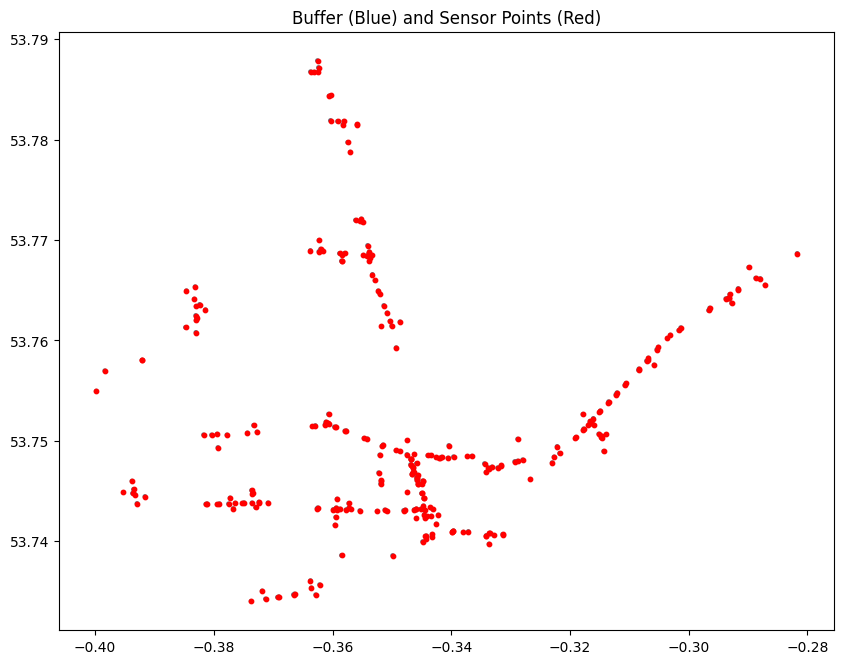

sensors_overlap:
Empty GeoDataFrame
Columns: [id, resource_id, package_id, name, description, longitude, latitude, desc, direction, url, geometry]
Index: []


In [96]:
# Check sf_sensors_raw
print("sf_sensors_raw:")
print(sf_sensors_raw)

# Check sensors_buffer
print("sensors_buffer:")
print(sensors_buffer)

# Check CRS
print("sf_sensors_raw CRS:", sf_sensors_raw.crs)
print("sensors_buffer CRS:", sensors_buffer.crs)

# Ensure both GeoDataFrames are in the same CRS
if sf_sensors_raw.crs != sensors_buffer.crs:
    sf_sensors_raw = sf_sensors_raw.to_crs(sensors_buffer.crs)

# Combine all geometries in sensors_buffer into a single polygon
buffer_groups = sensors_buffer.unary_union

# Create GeoDataFrame from buffer_groups
buffer_groups_gdf = gpd.GeoDataFrame(geometry=[buffer_groups], crs=sensors_buffer.crs)

# Check buffer_groups_gdf
print("buffer_groups_gdf:")
print(buffer_groups_gdf)

# Perform intersection
sensors_overlap = gpd.overlay(buffer_groups_gdf, sf_sensors_raw, how='intersection')

# Visualize both geometries
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
buffer_groups_gdf.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black')
sf_sensors_raw.plot(ax=ax, color='red', markersize=10)
plt.title('Buffer (Blue) and Sensor Points (Red)')
plt.show()

# Display the result
print("sensors_overlap:")
print(sensors_overlap)


## Flow Direction refining
The description of the count sites refers to the junction where the induction loops are installed, and not necessarily correspond to actual road where they are installed.

The sites shown in the map below, for example, are all described as “TSI047 COUNTY ROAD / BRICKNALL AVE”, but they correspond to the four arms of the junction with sensors on Fairfax Ave, Bricknell Ave, and National Ave.

In [99]:

# Filter the GeoDataFrame for specific descriptions
filtered_sensors = sf_sensors_raw[sf_sensors_raw['desc'].str.contains("TSI047 COUNTY ROAD / BRICKNALL AVE")]

# Check if filtered_sensors has any data
if filtered_sensors.empty:
    print("No data found for the specified description.")
else:
    # Calculate mean coordinates
    mean_lat = filtered_sensors.geometry.y.mean()
    mean_lon = filtered_sensors.geometry.x.mean()
    print(f"Mean Latitude: {mean_lat}, Mean Longitude: {mean_lon}")

    # Create a base map centered around the mean coordinates of the filtered sensors
    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=12, tiles='OpenStreetMap')

    # Add points (dots) to the map for the filtered sensors
    for _, row in filtered_sensors.iterrows():
        print(f"Adding marker for: {row['desc']} at ({row.geometry.y}, {row.geometry.x})")  # Debug print
        folium.CircleMarker(
            location=(row.geometry.y, row.geometry.x),
            color='darkgreen',           # Dot color
            radius=2,                   # Size of the dots
            fill=True,
            fill_opacity=0.7,          # Transparency
            popup=row['desc']           # Optional: popup with description
        ).add_to(m)

    # Save the interactive map
    m.save('selected_sites_map.html')  # Save to an HTML file
    print("Map saved as 'selected_sites_map.html'.")

# If in Jupyter Notebook, displaying the map
m  # Uncomment this line if running in Jupyter Notebook


Mean Latitude: 53.76406883333333, Mean Longitude: -0.38296966666666665
Adding marker for: TSI047 COUNTY ROAD / BRICKNALL AVE at (53.765343, -0.383146)
Adding marker for: TSI047 COUNTY ROAD / BRICKNALL AVE at (53.763051, -0.381409)
Adding marker for: TSI047 COUNTY ROAD / BRICKNALL AVE at (53.76494, -0.384615)
Adding marker for: TSI047 COUNTY ROAD / BRICKNALL AVE at (53.764118, -0.383282)
Adding marker for: TSI047 COUNTY ROAD / BRICKNALL AVE at (53.763573, -0.382389)
Adding marker for: TSI047 COUNTY ROAD / BRICKNALL AVE at (53.763388, -0.382977)
Map saved as 'selected_sites_map.html'.
